# _Gaia_ velocity distribution  (Niceb et al. 1807.02519, 1810.12301)

    Project: Direct Detection and Astrophysics

    Author : John Shing Chau Leung
    
    Description: Demonstrate and compare the velocity structures under SHM and Gaia

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import division    #for division operator
import math, numpy as np
from astropy import constants as const
from astropy import units as u
from astropy import coordinates as coord
from scipy.special import erf, spherical_jn, factorial
from scipy.integrate import quad, odeint, simps, nquad
import scipy.stats as stats
from scipy.interpolate import interp1d, interp2d, InterpolatedUnivariateSpline, griddata
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.transforms import Bbox
import warnings

from time import sleep
from tqdm import tqdm

import h5py
from sklearn import svm
from scipy.linalg import eig, eigvals
from random import randint
from itertools import cycle
import h5py
from scipy import interpolate

import swordfish as sf
from scipy.constants import c
from numpy.random import multivariate_normal
from matplotlib import rc
from scipy.interpolate import UnivariateSpline

import sys

sys.path.insert(0, "/Users/john/Desktop/direct_detection/code")

import operators as ops
import astrophys as fv

plt.style.use('seaborn-bright')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100

keVtoGeV= 1e-6 
invVelToUnitless = 3.0E5

## Velocity conversion for Earth's reference frame between coordinates systems

The part of this calculation is that the Earth's velocity model in references like astro-ph/0304446 and astro-ph/0607121 are written in galactic coordinates (l, b, r). The dark matter halo/substructure literature uses galactocentric coordinates. It is therefore a need to convert the Earth's velocity description to those of Milky Way dark matter. 

_VelocityFunctions( )_ is an object of _fv_ that calculate and generate $f(|v|)$ 3 dimensional DM velocity relative to the Earth.

In [3]:
f_of_v = fv.VelocityFunctions()

generating default halo


100%|██████████| 100/100 [00:11<00:00,  8.79it/s]


generating SHM


100%|██████████| 100/100 [00:11<00:00,  8.80it/s]


generating default halo


100%|██████████| 100/100 [00:11<00:00,  9.01it/s]


generating SHM


100%|██████████| 100/100 [00:11<00:00,  9.01it/s]


generating NLB full substructure


100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


generating NLB full halo


100%|██████████| 100/100 [00:11<00:00,  8.86it/s]


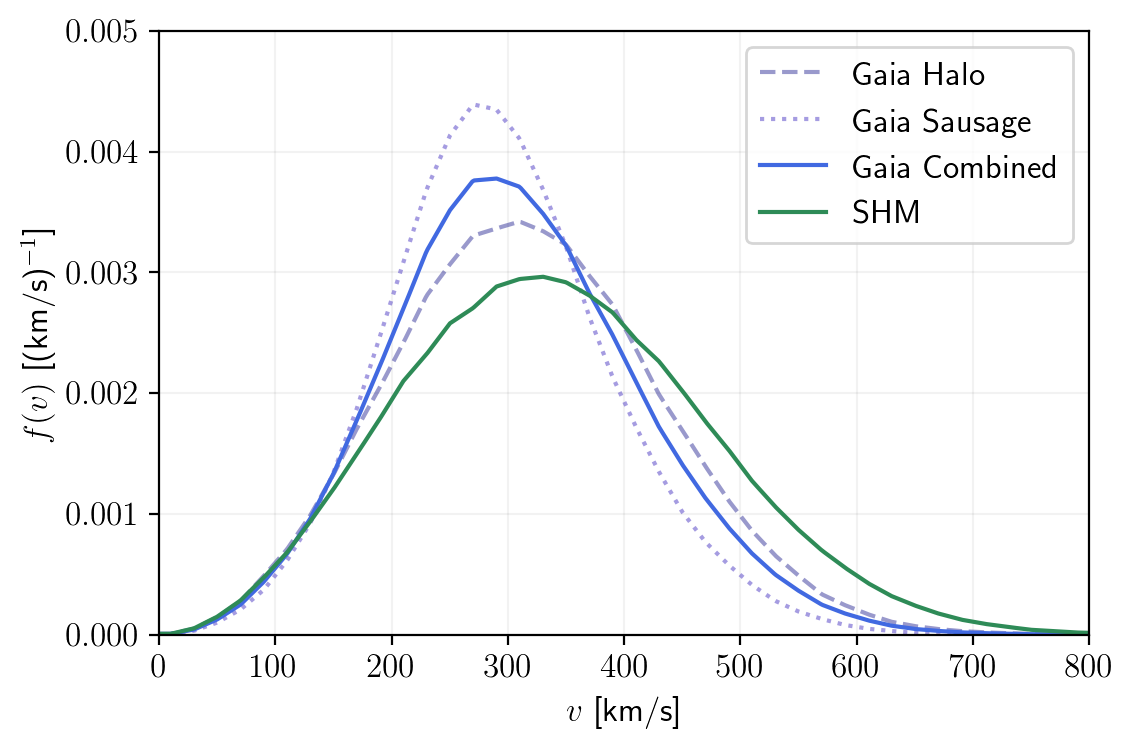

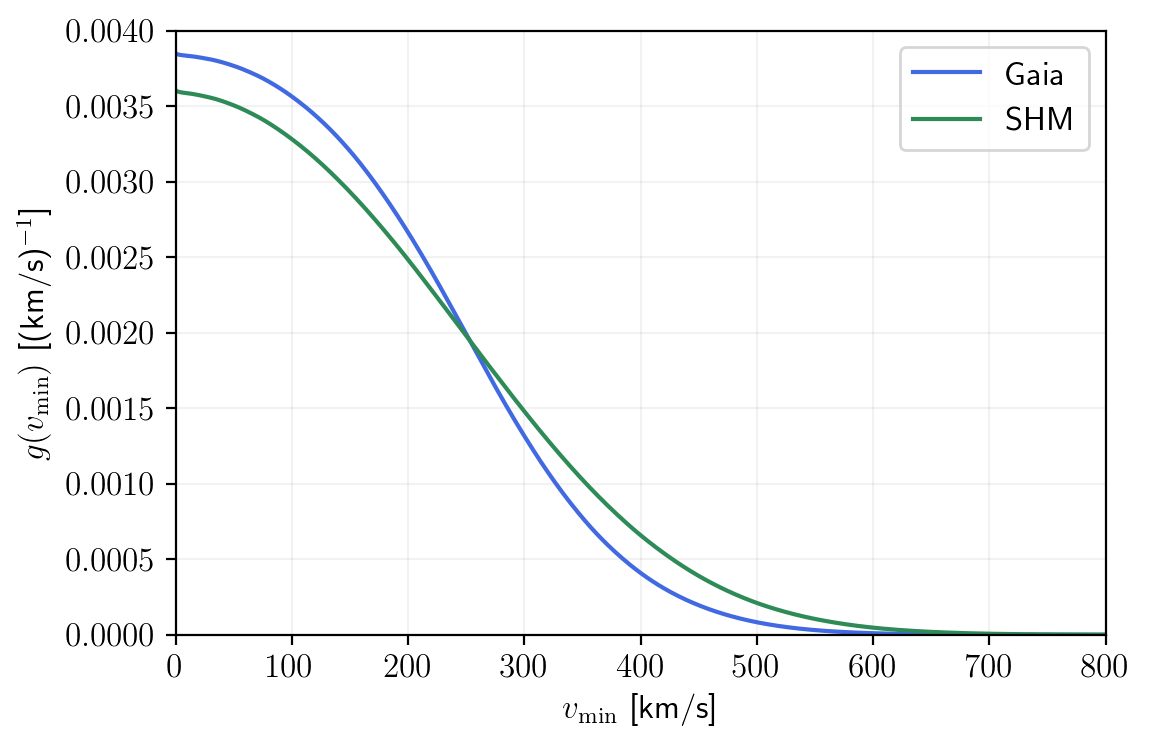

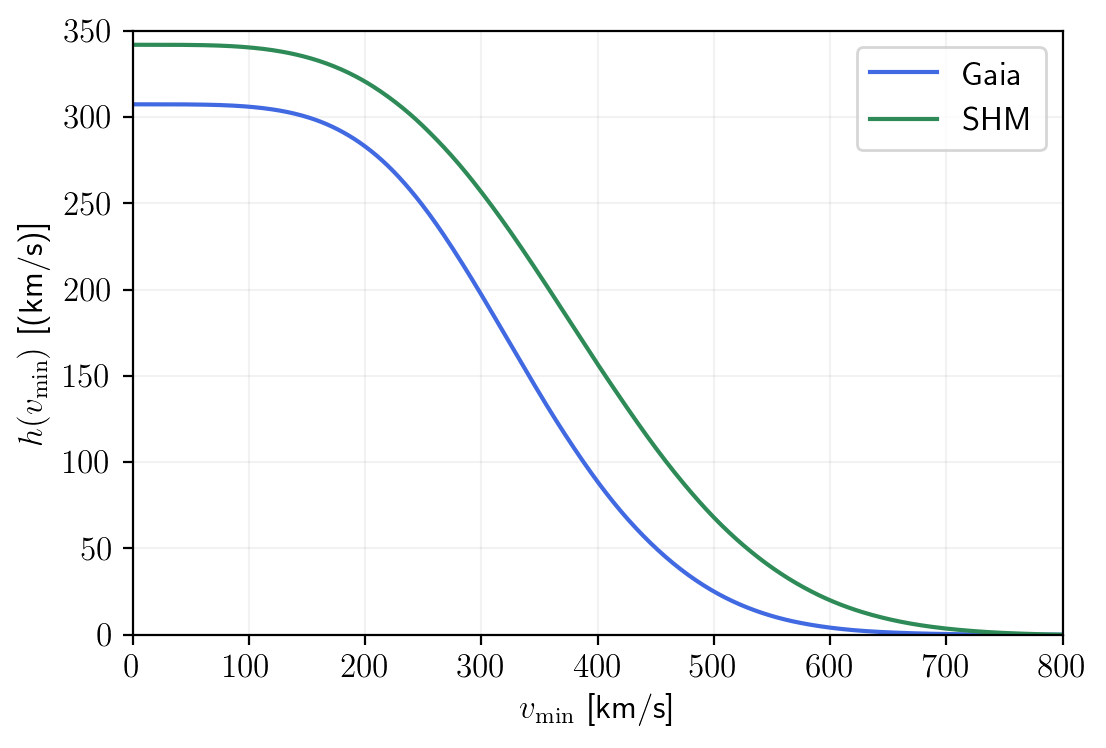

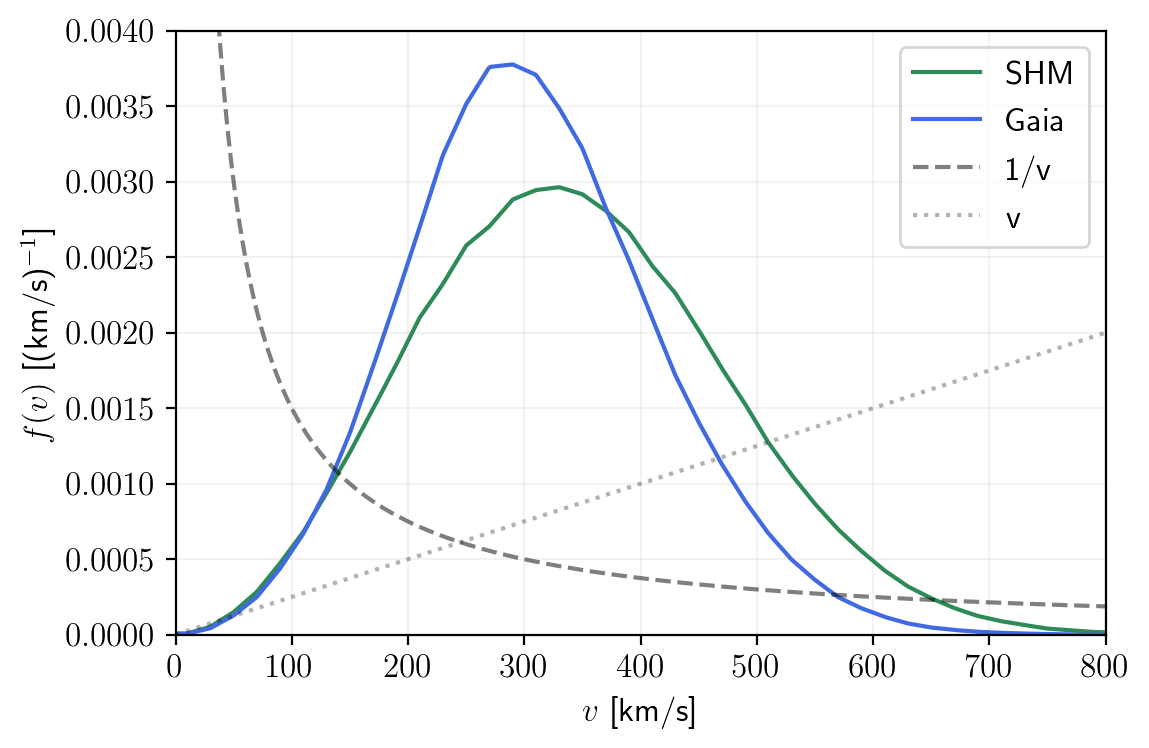

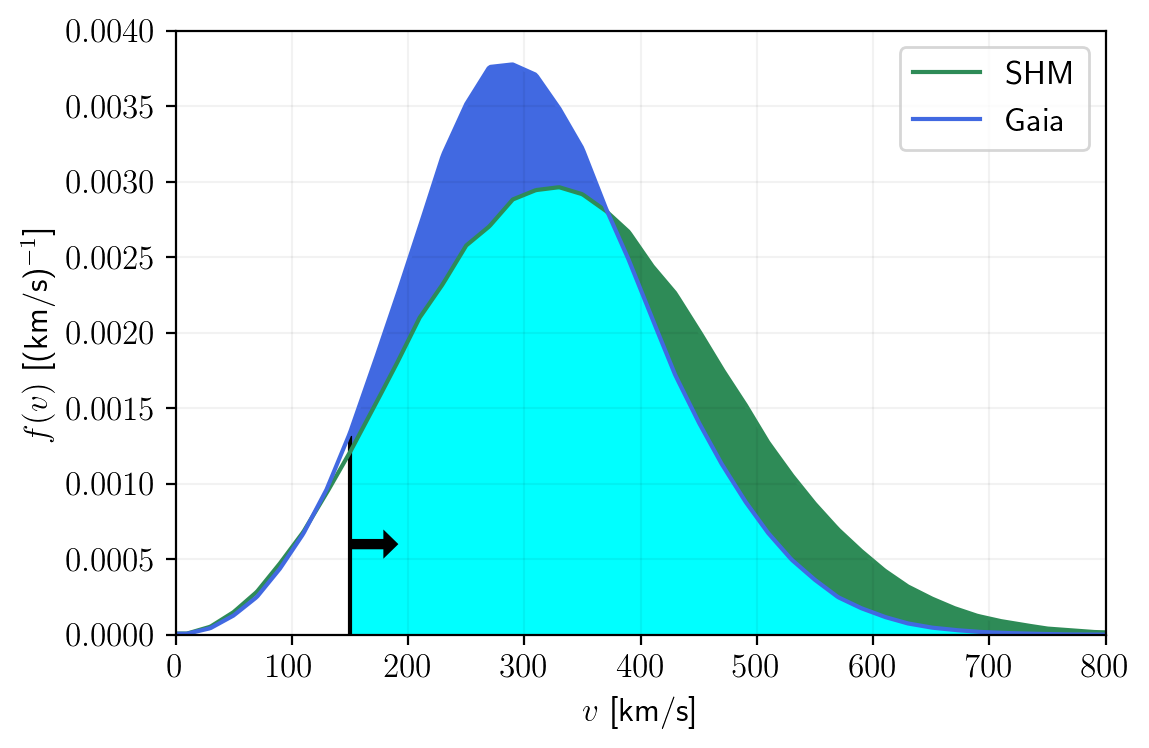

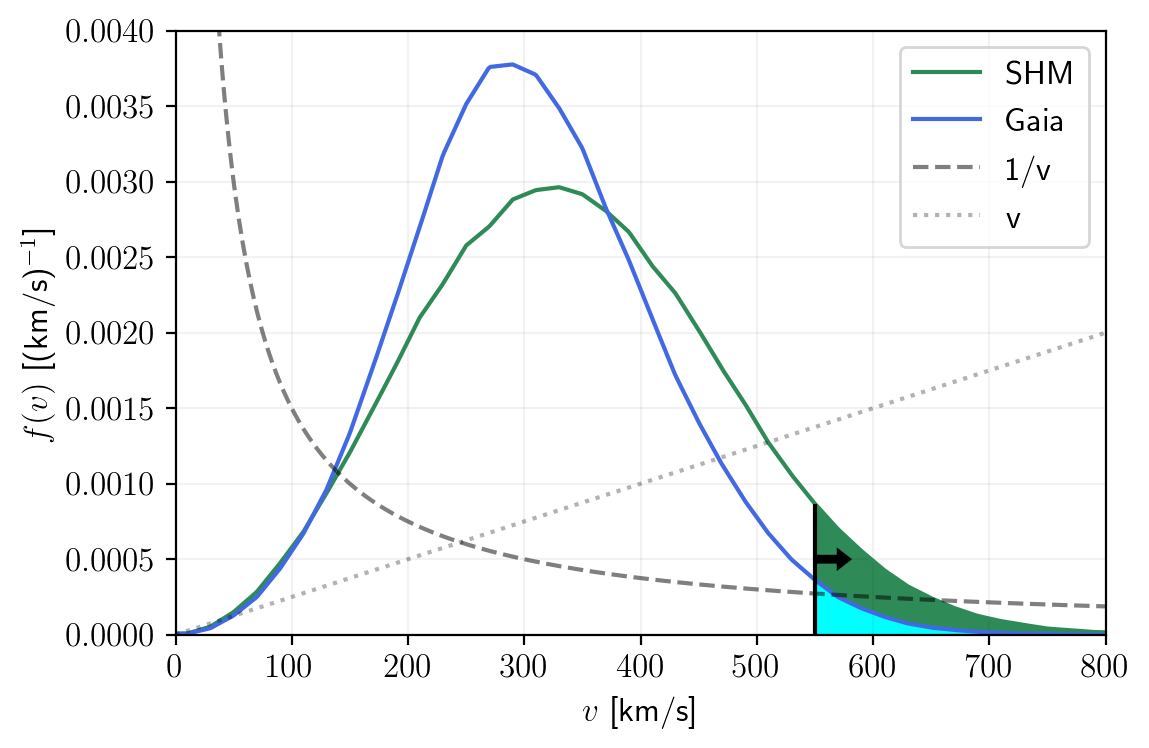

In [5]:
v_plot = np.linspace(0.01,800,500)
dv = v_plot[1] - v_plot[0]
frac_sub = 0.42
plt.rcParams["figure.figsize"] = (6, 4)
"""
y1 = f_of_v.fv_select(v_min, 'default', '1')
y2 = (1.-0.42)*f_of_v.fv_select(v_min, 'NLB_halo_full', '1') + 0.42*f_of_v.fv_select(v_min, 'NLB_subst_full', '1')
plt.plot(v_min, y1, color='g', label='SHM');
plt.plot(v_min, y2, color='r' , label='Gaia');
plt.ylabel(r'$h(v_{\rm min})$'); plt.xlabel(r'$v_{\rm min}$')
plt.ylim(0.,0.0012); plt.xlim(0.,800.)
plt.legend(); plt.show()"""


f_halo_v = f_of_v.load_fv('f_v_halo_normalized.txt')
f_subst_v = f_of_v.load_fv('f_v_substructure_normalized.txt')
f_shm_v = f_of_v.load_fv('maxwellboltzmann_helio.txt')
plt.plot(v_plot, f_halo_v(v_plot), label='Gaia Halo', color='navy', linestyle='--', alpha=0.4)
plt.plot(v_plot, f_subst_v(v_plot), label='Gaia Sausage', color='slateblue', linestyle=':', alpha=0.6)
plt.plot(v_plot, (1.-frac_sub)*f_halo_v(v_plot) + frac_sub*f_subst_v(v_plot), label='Gaia Combined', color='royalblue')
plt.plot(v_plot, f_shm_v(v_plot), label='SHM', color='seagreen')
plt.xlabel(r'$v$ [km/s]'); plt.ylabel(r'$f(v)$ [(km/s)$ ^{-1}$]'); plt.ylim(0.,0.005); plt.xlim(0.,800.)
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
plt.legend(); plt.savefig("f_v.pdf");
plt.show()

g_gaia_v = np.empty_like(v_plot)
g_shm_v = np.empty_like(v_plot)
for i, v_i in enumerate(v_plot):
    g_gaia_v[i] = np.sum((v_plot > v_i)*((1.-frac_sub)*f_halo_v(v_plot) + frac_sub*f_subst_v(v_plot))/v_plot)*dv
    g_shm_v[i] = np.sum((v_plot > v_i)*f_shm_v(v_plot)/v_plot)*dv
plt.plot(v_plot, g_gaia_v, label='Gaia', color='royalblue')
plt.plot(v_plot, g_shm_v, label='SHM', color='seagreen')
plt.xlabel(r'$v_{\min}$ [km/s]'); plt.ylabel(r'$g(v_{\min})$ [(km/s)$ ^{-1}$]'); plt.ylim(0.,0.004); plt.xlim(0.,800.)
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
plt.legend(loc='upper right'); plt.savefig("g_vmin.pdf");
plt.show()

h_gaia_v = np.empty_like(v_plot)
h_shm_v = np.empty_like(v_plot)
for i, v_i in enumerate(v_plot):
    h_gaia_v[i] = np.sum((v_plot > v_i)*((1.-frac_sub)*f_halo_v(v_plot) + frac_sub*f_subst_v(v_plot))*v_plot)*dv 
    h_shm_v[i] = np.sum((v_plot > v_i)*f_shm_v(v_plot)*v_plot)*dv
plt.plot(v_plot, h_gaia_v, label='Gaia', color='royalblue')
plt.plot(v_plot, h_shm_v, label='SHM', color='seagreen')
plt.xlabel(r'$v_{\min}$ [km/s]'); plt.ylabel(r'$h(v_{\min})$ [(km/s)]'); plt.ylim(0.,350.); plt.xlim(0.,800.)
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
plt.legend(loc='upper right'); plt.savefig("h_vmin.pdf");
plt.show()

y1 = f_shm_v(v_plot)
y2 = (1.-frac_sub)*f_halo_v(v_plot) + frac_sub*f_subst_v(v_plot)
plt.plot(v_plot, y1, color='seagreen', label='SHM')
plt.plot(v_plot, y2, color='royalblue', label='Gaia')
plt.plot(v_plot, 0.15/v_plot,  label='1/v', color='black', alpha=0.5, linestyle='--')
plt.plot(v_plot, 0.0000025*v_plot,  label='v', color='black', alpha=0.3, linestyle=':')
plt.xlabel(r'$v$ [km/s]'); plt.ylabel(r'$f(v)$ [(km/s)$ ^{-1}$]'); plt.ylim(0.,0.004); plt.xlim(0.,800.)
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
plt.legend(); plt.savefig("f_v_int_L.pdf");
plt.show()

v_min_sample=150
line0, = plt.plot([v_min_sample,v_min_sample], [0, 0.0013], color='black')
plt.arrow(v_min_sample, 0.0006, 30, 0., width=0.00005, head_length=10, color='black')
plt.plot(v_plot, y1, color='seagreen', label='SHM')
plt.plot(v_plot, y2, color='royalblue', label='Gaia')
plt.fill_between(v_plot, y1, np.zeros_like(v_plot), where=(v_plot>v_min_sample), facecolor='aqua', interpolate=True)
plt.fill_between(v_plot, y1, y2, where=(y2 <= y1)*(v_plot>v_min_sample), facecolor='seagreen', interpolate=True)
plt.fill_between(v_plot, y1, y2, where=(y2 >= y1)*(v_plot>v_min_sample), facecolor='royalblue', interpolate=True)
plt.xlabel(r'$v$ [km/s]'); plt.ylabel(r'$f(v)$ [(km/s)$ ^{-1}$]'); plt.ylim(0.,0.004); plt.xlim(0.,800.)
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
plt.legend(); plt.savefig("f_v_int_H.pdf");
plt.show()

plt.plot(v_plot, y1, color='seagreen', label='SHM')
plt.plot(v_plot, y2, color='royalblue', label='Gaia')
plt.plot(v_plot, 0.15/v_plot,  label='1/v', color='black', alpha=0.5, linestyle='--')
plt.plot(v_plot, 0.0000025*v_plot,  label='v', color='black', alpha=0.3, linestyle=':')

v_min_sample=550
line0, = plt.plot([v_min_sample,v_min_sample], [0, 0.00085], color='black')
plt.arrow(v_min_sample, 0.0005, 20, 0., width=0.00004, head_length=10, color='black')
plt.fill_between(v_plot, y1, np.zeros_like(v_plot), where=(v_plot>v_min_sample), facecolor='aqua', interpolate=True)
#plt.fill_between(v_plot, np.zeros_like(v_plot), y2, where=(y2 <= y1)*(v_plot>v_min_sample), facecolor='yellow', interpolate=True)
plt.fill_between(v_plot, y1, y2, where=(y2 <= y1)*(v_plot>v_min_sample), facecolor='seagreen', interpolate=True)
plt.fill_between(v_plot, y1, y2, where=(y2 >= y1)*(v_plot>v_min_sample), facecolor='royalblue', interpolate=True)
plt.xlabel(r'$v$ [km/s]'); plt.ylabel(r'$f(v)$ [(km/s)$ ^{-1}$]'); plt.ylim(0.,0.004); plt.xlim(0.,800.)
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
plt.legend(); plt.savefig("f_v_int_L.pdf");
plt.show()